In [22]:
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image                  
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [23]:
# Pretty display for notebooks
%matplotlib inline

In [24]:
# !ls

In [25]:
TEST_DIR = os.path.join(os.getcwd(),"imgs","test")
TRAIN_DIR = os.path.join(os.getcwd(),"imgs","train")
MODEL_PATH = os.path.join(os.getcwd(),"model","self_trained")
PICKLE_DIR = os.path.join(os.getcwd(),"pickle_files")
CSV_DIR = os.path.join(os.getcwd(),"csv_files")

In [26]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

Testing data does not exists
Training data does not exists


In [27]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(),"csv_files",filename),index=False)

create_csv(r"C:\Users\omkar\Desktop\Distracted Driver Detection\Distracted Driver Detection\train","train.csv")
create_csv(r"C:\Users\omkar\Desktop\Distracted Driver Detection\Distracted Driver Detection\test","test.csv")
data_train = pd.read_csv(os.path.join(os.getcwd(),"csv_files","train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(),"csv_files","test.csv"))

In [28]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filename   22424 non-null  object
 1   ClassName  22424 non-null  object
dtypes: object(2)
memory usage: 350.5+ KB


In [29]:
data_train['ClassName'].value_counts()

ClassName
c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: count, dtype: int64

In [30]:
data_train.describe()

,Filename,ClassName
count,22424,22424
unique,22424,10
top,C:\Users\omkar\Desktop\Distracted Driver Detec...,c0
freq,1,2489


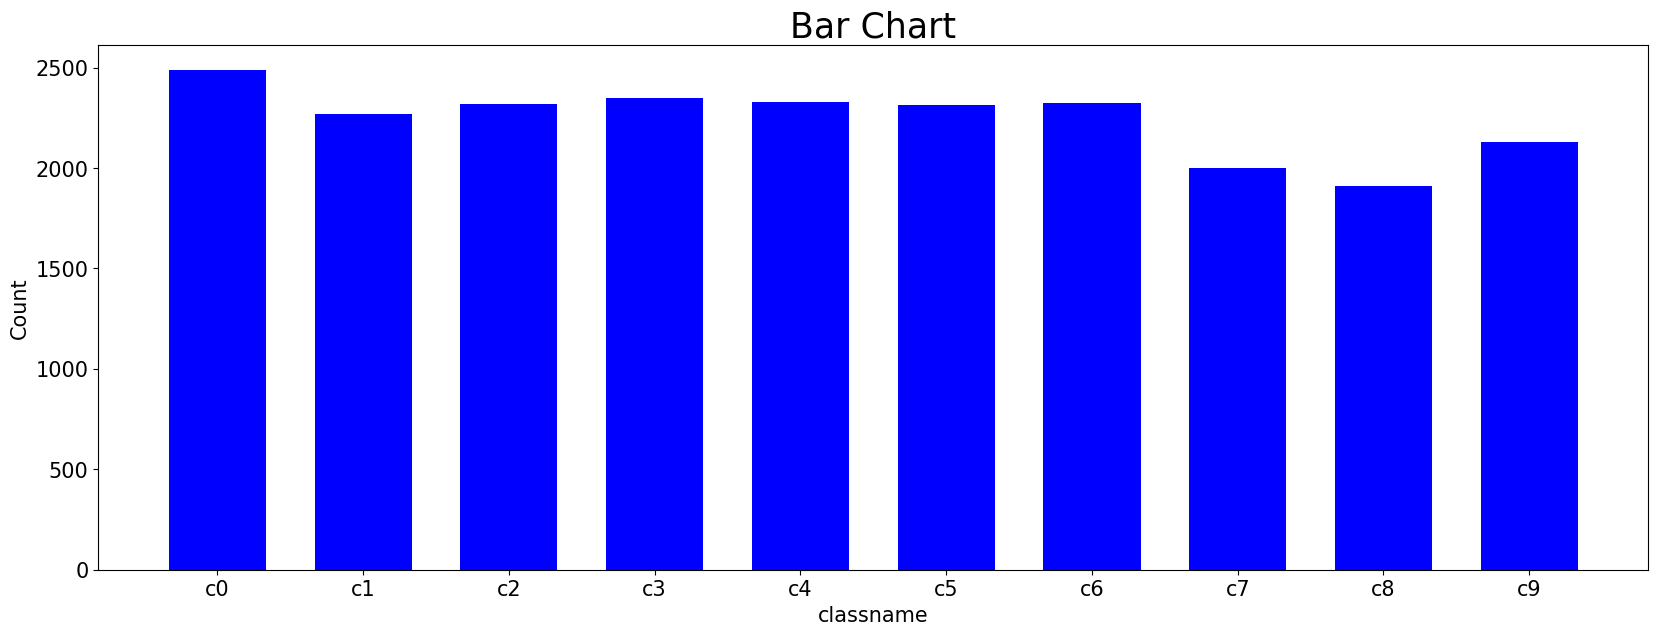

In [31]:
nf = data_train['ClassName'].value_counts(sort=False)
labels = data_train['ClassName'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

In [32]:
data_test.head()

,FileName,ClassName
0,C:\Users\omkar\Desktop\Distracted Driver Detec...,test
1,C:\Users\omkar\Desktop\Distracted Driver Detec...,test
2,C:\Users\omkar\Desktop\Distracted Driver Detec...,test
3,C:\Users\omkar\Desktop\Distracted Driver Detec...,test
4,C:\Users\omkar\Desktop\Distracted Driver Detec...,test


In [33]:
data_test.shape

(4961, 2)

In [35]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c5': 0, 'c9': 1, 'c3': 2, 'c7': 3, 'c8': 4, 'c0': 5, 'c6': 6, 'c4': 7, 'c2': 8, 'c1': 9}


In [36]:
with open(os.path.join(os.getcwd(),"pickle_files","labels_list.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

In [37]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)

(22424, 10)


In [38]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)

In [39]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(128, 128))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [40]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17939/17939 [04:22<00:00, 68.32it/s]


In [41]:
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4485/4485 [01:05<00:00, 68.94it/s]


In [43]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(128,128,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      832       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       32896     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 256)       131328    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 256)      

In [44]:
plot_model(model,to_file=os.path.join(MODEL_PATH,"model_distracted_driver.png"),show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [45]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [47]:
model_history = model.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=25, batch_size=40, shuffle=True,callbacks=callbacks_list)

Epoch 1/25


449/449 [==============================] - ETA: 0s - loss: 0.9827 - accuracy: 0.6656
Epoch 1: val_accuracy improved from -inf to 0.93043, saving model to C:\Users\omkar\model\self_trained\distracted-01-0.93.hdf5


C:\Users\omkar\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


449/449 [==============================] - 331s 728ms/step - loss: 0.9827 - accuracy: 0.6656 - val_loss: 0.2387 - val_accuracy: 0.9304
Epoch 2/25
449/449 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9353
Epoch 2: val_accuracy improved from 0.93043 to 0.96143, saving model to C:\Users\omkar\model\self_trained\distracted-02-0.96.hdf5
449/449 [==============================] - 319s 711ms/step - loss: 0.2139 - accuracy: 0.9353 - val_loss: 0.1256 - val_accuracy: 0.9614
Epoch 3/25
449/449 [==============================] - ETA: 0s - loss: 0.1181 - accuracy: 0.9667
Epoch 3: val_accuracy improved from 0.96143 to 0.98439, saving model to C:\Users\omkar\model\self_trained\distracted-03-0.98.hdf5
449/449 [==============================] - 317s 705ms/step - loss: 0.1181 - accuracy: 0.9667 - val_loss: 0.0569 - val_accuracy: 0.9844
Epoch 4/25
449/449 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9765
Epoch 4: val_accuracy improved from 0.98439 to 

In [48]:
model.save('Distracted_model.h5')    